# Classifier of face features based on latent activations

1. Collect activations of latent for each sample from the dataset 
2. Load df with face features assigned to each sample
3. Create classifiers
4. From the weights of classifiers find which feature does each latent activate for the most

## Preliminaries

In [1]:
import os
from copy import deepcopy

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
from safetensors.torch import load_file
from sae.sae import EncoderOutput

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score

Triton not installed, using eager implementation of SAE decoder.


In [2]:
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights

In [3]:
path = "weights2weights/weights_datasets"
device = "cuda"

### Load SAE

In [4]:
from sae import Sae
sae_path = "runs/test_feature_logging/0"
sae = Sae.load_from_disk(sae_path,device=device)
sae.eval()

Sae(
  (encoder): Linear(in_features=99648, out_features=5000, bias=True)
)

### Load diffusion

In [5]:
model_path = os.path.join(os.getcwd(), "base_model")
base_weights = load_file(f"{model_path}/unet/adapter_model.safetensors")

pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, f"{model_path}/unet", adapter_name="identity1")
# adapters_weights1 = load_peft_weights(f"{model_path}/unet", device="cuda:0")
pipe.unet.load_state_dict(base_weights, strict = False)
pipe.to(device)
pass


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [6]:
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person" #"sks person in a hat in a forest"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
# #run inference
# image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
# image

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/peft/tuners/lora/model.py:364: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


## Collect activations

In [ ]:
!python notebooks/collect_activations.py

In [7]:
activations = torch.load(f"{path}/activations.pt")

In [ ]:
for k, v in activations.items():
    print(v.sum())

## Face features df

In [8]:
df = torch.load(f"{path}/identities/identity_df.pt")

In [9]:
df["filename"] = df.index.str.split(".").str[0]

## Linear classifiers

In [10]:
filenames = list(activations.keys())
X = torch.stack([activations[f] for f in filenames]).cpu().numpy()

In [11]:
filenames = [os.path.splitext(f)[0] for f in filenames]
filenames[0]

'000005'

In [12]:
df = df.loc[df.filename==filenames]
df.shape

(64974, 42)

In [13]:
y_cols = df.drop(columns=["filename", "identity"]).columns

In [14]:
Y = df[y_cols].values 
Y

array([[-1,  1,  1, ..., -1, -1,  1],
       [ 1, -1,  1, ..., -1, -1,  1],
       [ 1,  1, -1, ..., -1, -1,  1],
       ...,
       [-1, -1,  1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1,  1],
       [-1,  1,  1, ..., -1, -1,  1]])

In [15]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069],
       [-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069],
       [-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069],
       ...,
       [-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069],
       [-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069],
       [-0.01033051, -0.02657578, -0.01958529, ..., -0.09804916,
        -0.02797009, -0.07570069]], dtype=float32)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [18]:
classifiers = {}

for i, col in enumerate(y_cols):
    clf = LogisticRegression(max_iter=10, class_weight="balanced", random_state=42)
    if len(set(Y_train[:, i])) ==2:
        clf.fit(X_train, Y_train[:, i])
        classifiers[col] = clf
    else:
        print(f"{len(set(Y_train[:, i]))} classes for {col}")

/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

1 classes for Wearing_Hat


/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/net/tscratch/people/plgkingak/w2w/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [19]:
for col, clf in classifiers.items():
    Y_pred = clf.predict(X_test)
    acc = balanced_accuracy_score(Y_test[:, y_cols.get_loc(col)], Y_pred)
    print(f"{col} Accuracy: {acc:.4f}")

5_o_Clock_Shadow Accuracy: 0.8680
Arched_Eyebrows Accuracy: 0.7862
Attractive Accuracy: 0.7998
Bags_Under_Eyes Accuracy: 0.7595
Bald Accuracy: 0.9373
Bangs Accuracy: 0.9305
Big_Lips Accuracy: 0.6891
Big_Nose Accuracy: 0.7676
Black_Hair Accuracy: 0.8512
Blond_Hair Accuracy: 0.9190
Blurry Accuracy: 0.6884
Brown_Hair Accuracy: 0.7633
Bushy_Eyebrows Accuracy: 0.8240
Chubby Accuracy: 0.8538
Double_Chin Accuracy: 0.8675
Eyeglasses Accuracy: 0.9828
Goatee Accuracy: 0.9331
Gray_Hair Accuracy: 0.9178
Heavy_Makeup Accuracy: 0.9022
High_Cheekbones Accuracy: 0.8145
Male Accuracy: 0.9917
Mouth_Slightly_Open Accuracy: 0.6857
Mustache Accuracy: 0.8909
Narrow_Eyes Accuracy: 0.7298
No_Beard Accuracy: 0.9344
Oval_Face Accuracy: 0.6579
Pale_Skin Accuracy: 0.7439
Pointy_Nose Accuracy: 0.6964
Receding_Hairline Accuracy: 0.8304
Rosy_Cheeks Accuracy: 0.8159
Sideburns Accuracy: 0.9429
Smiling Accuracy: 0.8497
Straight_Hair Accuracy: 0.7632
Wavy_Hair Accuracy: 0.8247
Wearing_Earrings Accuracy: 0.8631
Wearing_L

### Check classifier weights (effect on each latent)

In [210]:
weights = [clf.coef_ for clf in classifiers.values()]
weights[-1:]

[array([[ 0.00731306, -0.02050911,  0.01651861, ..., -0.0290402 ,
          0.02144047,  0.0084992 ]])]

In [229]:
tops = []
for w in weights:
    tops.append(np.abs(w).argsort()[0, :100])

### Testing one feature

In [588]:
classifiers.keys()

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])

In [434]:
col = "Bushy_Eyebrows"
col

'Bushy_Eyebrows'

In [435]:
clf = classifiers[col]

In [649]:
w = clf.coef_.flatten()
b = clf.intercept_ 

x = X[0]

eta = -2
x_modified = x + eta * w

In [650]:
i = np.abs(w).argsort()[-1:]

In [651]:
i

array([1479])

In [706]:
x_modified_2 = x.copy()
x_modified_2[i] = x_modified_2[i] +25*w[i]

In [707]:
z = np.dot(w, x) + b
predicted_label = 1 if z > 0 else 0
print(predicted_label)
z_modified = np.dot(w, x_modified) + b
predicted_label = 1 if z_modified > 0 else 0
print(predicted_label)
z_modified = np.dot(w, x_modified_2) + b
predicted_label = 1 if z_modified > 0 else 0
print(predicted_label)

0
0
0


In [708]:
x_new = scaler.inverse_transform(x_modified.reshape(1,-1))
x_new2 = scaler.inverse_transform(x_modified_2.reshape(1,-1))
x_orig = scaler.inverse_transform(x.reshape(1,-1))

In [709]:
# in_x = x_orig
# acts= torch.tensor(in_x[0])
# indices = torch.tensor(range(in_x.shape[1]))
# ##
# k = 1000
# indices = acts.topk(k).indices
# acts = acts.topk(k).values
# ##

# e2 = EncoderOutput(top_acts=acts.to(device),
#                     top_indices=indices.to(device))

In [710]:
in_x = x_orig
acts= torch.tensor(in_x[0])
# indices = torch.tensor(range(in_x.shape[1]))
##
k = 1000
indices = acts.topk(k).indices
acts = torch.tensor(x_new2[0])[indices] 
##

e2 = EncoderOutput(top_acts=acts.to(device),
                    top_indices=indices.to(device))

  0%|          | 0/50 [00:00<?, ?it/s]

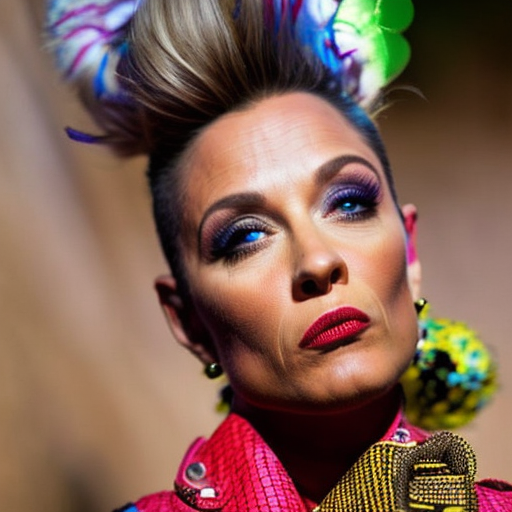

In [711]:
weights_out = sae.decode(e2.top_acts, e2.top_indices)

new_weights = deepcopy(base_weights)
start_idx = 0

for key in base_weights.keys():
    shape = base_weights[key].shape
    end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
    new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
    start_idx = end_idx
pipe.unet.load_state_dict(new_weights, strict = False)
pipe.to(device)
image1 = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image1

In [716]:
list(classifiers.keys())

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [713]:
weights[:, 1479]

array([ 0.00451561, -0.05620094, -0.05055966, -0.02254172,  0.00466653,
        0.02548702,  0.03397151,  0.00527216, -0.0409596 ,  0.02099774,
        0.06622163,  0.04682515, -0.28647529,  0.03076315,  0.02881141,
        0.00153299,  0.00136429,  0.00326433, -0.04954068, -0.08329139,
        0.00171461,  0.23491177,  0.00903575,  0.01051262,  0.0262741 ,
       -0.03298334, -0.01128779, -0.02749652,  0.0173014 , -0.06038013,
       -0.01280808, -0.09861988, -0.01178742,  0.03282839, -0.04190344,
        0.00149213, -0.01453925,  0.0318556 ,  0.00252138])

## Correspondence

In [25]:
weights = np.array([clf.coef_[0] for clf in classifiers.values()])
weights.shape

(39, 5000)

#### Threshold assignement

In [290]:
threshold = np.percentile(np.abs(weights), 80)
abs(weights).min(), abs(weights).max(), abs(weights).mean(), abs(weights).std(), threshold

(0.0,
 0.862348793375311,
 0.018453762403124668,
 0.021501543347428168,
 0.02836798966642551)

In [293]:
h_weights = (abs(weights) > threshold)

In [294]:
assignments = {k:np.where(h_weights[i])[0] for i, k in enumerate(classifiers.keys())}

In [295]:
feature_sets = {key: set(values) for key, values in assignments.items()}
filtered_assignements = {
    key: list(values - set().union(*(feature_sets[k] for k in feature_sets if k != key)))
    for key, values in feature_sets.items()
}
filtered_assignements

{'5_o_Clock_Shadow': [4940, 2254],
 'Arched_Eyebrows': [1697, 3695],
 'Attractive': [3383],
 'Bags_Under_Eyes': [256, 386, 4390, 2889, 1873, 1724, 3966, 4447],
 'Bald': [1295],
 'Bangs': [512, 1927, 2349, 178, 1299, 1589, 1406],
 'Big_Lips': [],
 'Big_Nose': [],
 'Black_Hair': [3634, 795],
 'Blond_Hair': [4201, 3890, 124, 533],
 'Blurry': [394,
  2202,
  1566,
  3755,
  4653,
  4924,
  1853,
  4415,
  2624,
  1859,
  196,
  966,
  4561,
  2265,
  4191,
  741,
  4589,
  3319,
  1022,
  3967],
 'Brown_Hair': [2469, 3301, 4935, 4904, 2409, 268, 2924, 340, 2421],
 'Bushy_Eyebrows': [517, 2313, 560, 889, 4605],
 'Chubby': [1325, 4816, 818, 2358, 4535, 158],
 'Double_Chin': [4494, 1750, 983, 3390, 3615],
 'Eyeglasses': [],
 'Goatee': [3979],
 'Gray_Hair': [73, 2350, 3825, 3378, 2876],
 'Heavy_Makeup': [625, 3507, 4630],
 'High_Cheekbones': [2147, 2854],
 'Male': [2345, 3089],
 'Mouth_Slightly_Open': [1284,
  1416,
  397,
  2964,
  2967,
  2585,
  3738,
  2971,
  288,
  2087,
  298,
  2483,
 

#### Max assignement

In [28]:
assignments = np.argmax(np.abs(weights), axis=0)

In [34]:
k = [k for k in classifiers.keys()]

In [35]:
assignments

array([21, 23, 29, ..., 30, 10,  9])

In [38]:
unique_features = np.unique(assignments)
grouped_indices = {name: np.where(assignments == i)[0] for i, name in enumerate(k)}
torch.save(grouped_indices, f"{path}/feature_correspondence.pt")

In [ ]:
grouped_indices = torch.load(f"{path}/feature_correspondence.pt")

### Testing features

In [274]:
x = X[0]
x_orig = scaler.inverse_transform(x.reshape(1,-1))[0]

In [275]:
grouped_indices

{'5_o_Clock_Shadow': array([  75,  154,  163,  175,  220,  230,  255,  330,  337,  528,  587,
         591,  660,  763,  781,  820,  842,  853,  943, 1177, 1330, 1511,
        1526, 1653, 1654, 1666, 1668, 1899, 2129, 2254, 2376, 2380, 2546,
        2580, 2584, 2621, 2626, 2694, 2861, 2862, 2887, 2944, 2991, 3056,
        3180, 3194, 3268, 3356, 3418, 3667, 3685, 3723, 3889, 4178, 4236,
        4323, 4380, 4497, 4627, 4740, 4864, 4874, 4940]),
 'Arched_Eyebrows': array([  25,   66,   76,  301,  408,  419,  438,  923, 1317, 1360, 1476,
        1540, 1627, 1631, 1697, 1916, 2056, 2589, 2639, 2725, 2728, 2936,
        2954, 3612, 3624, 3655, 3695, 3735, 3839, 3861, 4014, 4118, 4354,
        4729, 4781]),
 'Attractive': array([ 580,  671, 1370, 3383, 4302]),
 'Bags_Under_Eyes': array([ 256,  258,  324,  386,  547,  569,  737,  996, 1229, 1483, 1498,
        1536, 1645, 1724, 1873, 1902, 2025, 2116, 2340, 2503, 2564, 2654,
        2675, 2806, 2889, 2909, 3029, 3385, 3402, 3640, 3688, 3856, 

In [371]:
feat_indices = assignments['5_o_Clock_Shadow']

In [376]:
x_new = x_orig.copy()

x_new[feat_indices] = x_new[feat_indices] * +2

In [377]:
x_orig[feat_indices], x_new[feat_indices]
pass

In [378]:
# in_x = x_orig
# acts= torch.tensor(in_x)

# ##
# k = 1000
# indices = acts.topk(k).indices
# acts = torch.tensor(x_new)[indices] 
# ##

# e2 = EncoderOutput(top_acts=acts.to(device),
#                     top_indices=indices.to(device))

in_x = x_new
acts= torch.tensor(in_x)
indices = torch.tensor(range(in_x.shape[0]))
##
# k = 1000
# indices = acts.topk(k).indices
# acts = torch.tensor(x_new)[indices] 
##

e2 = EncoderOutput(top_acts=acts.to(device),
                    top_indices=indices.to(device))

  0%|          | 0/50 [00:00<?, ?it/s]

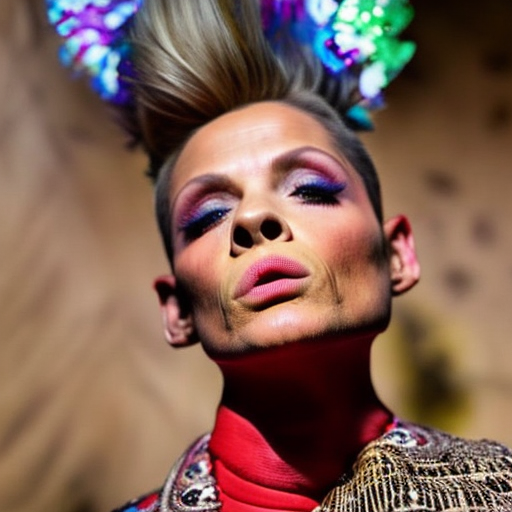

In [379]:
weights_out = sae.decode(e2.top_acts, e2.top_indices)

new_weights = deepcopy(base_weights)
start_idx = 0

for key in base_weights.keys():
    shape = base_weights[key].shape
    end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
    new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
    start_idx = end_idx
pipe.unet.load_state_dict(new_weights, strict = False)
pipe.to(device)
image1 = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image1

### Check one by one

In [119]:
for i in feat_indices:
    x_new = x_orig.copy()

    x_new[i] = x_new[i] * -50
    in_x = x_new
    acts= torch.tensor(in_x)
    indices = torch.tensor(range(in_x.shape[0]))
    ##
    # k = 1000
    # indices = acts.topk(k).indices
    # acts = torch.tensor(x_new)[indices] 
    ##

    e2 = EncoderOutput(top_acts=acts.to(device),
                    top_indices=indices.to(device))
    
    weights_out = sae.decode(e2.top_acts, e2.top_indices)

    new_weights = deepcopy(base_weights)
    start_idx = 0

    for key in base_weights.keys():
        shape = base_weights[key].shape
        end_idx = start_idx + torch.prod(torch.tensor(shape)).item()  # Calculate end index
        new_weights[key] = weights_out[start_idx:end_idx].reshape(*shape)
        start_idx = end_idx
    pipe.unet.load_state_dict(new_weights, strict = False)
    pipe.to(device)
    image1 = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
    display(image1)
    